In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

5

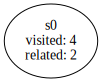

In [4]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


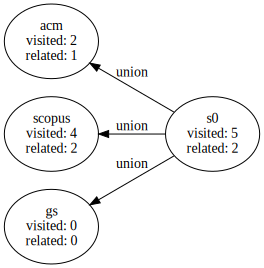

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [6]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.5
Recall E1
0.4


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

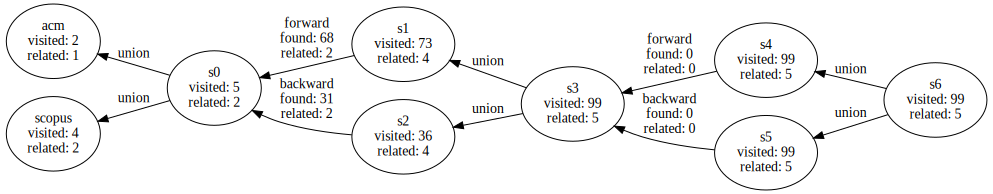

In [200]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

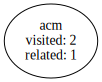

In [201]:
strategy.initial.find("acm")

In [202]:
# Visitados ACM
strategy.initial.find("acm").visited

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review}

In [203]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Further comparison of cross-company and within-company effort estimation models for web applications}

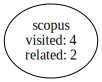

In [204]:
strategy.initial.find("scopus")

In [205]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Using public domain metrics to estimate software development effort,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [206]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [207]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


{Further comparison of cross-company and within-company effort estimation models for web applications}

#### Resumo do Snowballing

In [208]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


94

In [209]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{A comparison of cross-company and within-company effort estimation models for web applications,
 Building software cost estimation models using homogenous data,
 Cross versus within-company cost estimation studies: A systematic review}

In [210]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
 'premraj2007a - Building software cost estimation models using homogenous data',
 'kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [211]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Using public domain metrics to estimate software development effort,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

#### Relacionados - Seed Set

In [212]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['mendes2004a - Further comparison of cross-company and within-company effort estimation models for web applications',
 'ferrucci2012a - Web effort estimation: The value of cross-company data set compared to single-company data set']

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [213]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Exploiting the essential assumptions of analogy-based effort estimation,
 Case studies for method and tool evaluation,
 When to use data from other projects for effort estimation,
 Assessment and comparison of common software cost estimation modeling techniques,
 Software cost models,
 Applied statistics for software managers,
 An empirical validation of software cost estimation models,
 Individual comparisons by ranking methods,
 On the relative value of cross-company and within-company data for defect prediction,
 The need for web engineering: An introduction,
 Effort estimation: how valuable is it for a web company to use a cross-company data set, compared to using its own single-company data set?,
 Detection of influential observation in linear regression,
 Statistical power analysis for the behavioral sciences,
 What accuracy statistics really measure,
 A study of project selection and feature weighting for analogy based software cost estimation,
 A procedure for analyzing unbala

In [214]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
 'kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [215]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['premraj2007a - Building software cost estimation models using homogenous data',
 'kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review']

#### Relacionados - Encontrados Via Backward e Forward

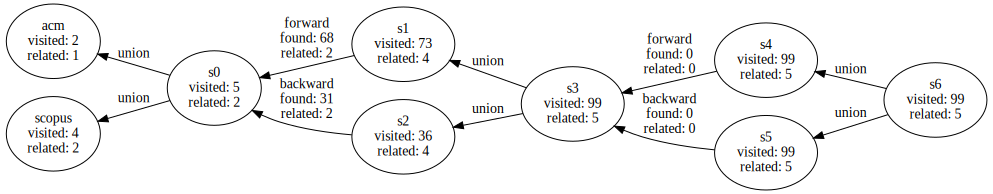

In [216]:
state

In [217]:
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited)) - len(state.find("s0").visited)

1

In [218]:
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
  'kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review'],
 ['premraj2007a - Building software cost estimation models using homogenous data',
  'kitchenham2007a - Cross versus within-company cost estimation studies: A systematic review']]

In [219]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [220]:
strategy.forward??

In [221]:
duplicados(strategy, state)

0

In [222]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [223]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['kitchenham2004a', 'kitchenham2007a']
Forward ['premraj2007a', 'kitchenham2007a']


In [224]:
state.find("s0").related @ metakey

['mendes2004a', 'ferrucci2012a']

In [225]:
#x = v.get_patch_by_id('100')

In [226]:
#x.set_linestyle = "black"

In [227]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [228]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward mendes2004a
- christodoulou2000a 
- wilcoxon1945a 
- kitchenham2004a related
- kemerer1987a 
- kitchenham2001a 
- mendes2003a 
- cook1977a 
- wieczorek2002a 
- briand1999a 
- briand2000a 
- mendes2003b 
- shepperd2001a 
- kitchenham1984a 
- maxwell2002a 
- kitchenham1998a 
forward mendes2004a
- mendes2008b 
- mendes2005b 
- kitchenham2007a related
- mendes2007a 
- kocaguneli2010a 
backward ferrucci2012a
- kocaguneli2012a 
- kitchenham1995a 
- kocaguneli2010a 
- maxwell2002a 
- turhan2009a 
- mendes2005a 
- mendes2007a 
- cook1977a 
- cohen1988a 
- kitchenham2001a 
- li2009a 
- kitchenham1998a 
- mendes2008b 
- menzies2011a 
- kitchenham2007a related
- mendes2003a 
- conte1986a 
- mendes2005b 
- shepperd2001a 
- mendes2002a 
- kocaguneli2011a 
- kitchenham2004a related
- mendes2008a 


#### Execução de Forward em cada artigo relacionado do S1

In [229]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward mendes2004a
- mittas2010a 
- ferrucci2015a 
- kitchenham2006a 
- martino2007a 
- martino2011a 
- wieringa2015a 
- matos2013a 
- mendes2008d 
- mendes2007d 
- kocaguneli2010a 
- costagliola2006a 
- premraj2005a 
- lokan2008a 
- lang2009a 
- corazza2011a 
- huang2008a 
- marco2013a 
- baresi2007a 
- mendes2007c 
- mendes2007a 
- buglione2010a 
- wen2012a 
- mendes2007b 
- baker2010a 
- martino2016a 
- shepperd2012a 
- costagliola2006b 
- mittas2010b 
- mendes2008b 
- martino2009a 
- kitchenham2007a related
- al2006a 
- mendes2009b 
- mendes2005c 
- keung2008b 
- watanabe2008a 
- marco2012a 
- azhar2013a 
- lokan2006a 
- zimmermann2009a 
- keung2008a 
- keung2009a 
- ferrucci2008a 
- mittas2015a 
- mendes2009a 
- minku2015a 
- francese2015a 
- corazza2013a 
- ferrucci2009a 
- mendes2005b 
- corazza2009a 
- mair2005a 
- mendes2008e 
- abrahão2010a 
- premraj2007a related
- lall2006a 
- ferrucci2010b 
- ferrucci20

#### Resumo do Precision e Recall

In [230]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.03%
Precision no Snowballing E2 - Forward - 1 iteração: 0.03%
Precision no Snowballing E2 - Backward - 1 iteração: 0.06%

Precision E2 (Busca + Snowballing): 0.05%
Precision E2
0.050505050505050504
Recall E2
1.0


In [236]:
0 /0 

ZeroDivisionError: division by zero

In [281]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [295]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

9,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,scopus,0.5,0.4,-,2,4,2,4,0.5,0.4
1,acm,0.5,0.2,-,1,2,1,2,0.5,0.2
2,s0,0,0,union,2,5,0,0,0.4,0.4
3,s2,0.0645161,0.4,backward,4,36,2,31,0.111111,0.8
4,s1,0.0294118,0.4,forward,4,73,2,68,0.0547945,0.8
5,s3,0,0,union,5,99,0,0,0.0505051,1
6,s5,0,0,backward,5,99,0,0,0.0505051,1
7,s4,0,0,forward,5,99,0,0,0.0505051,1
8,s6,0,0,union,5,99,0,0,0.0505051,1


<IPython.core.display.Javascript object>


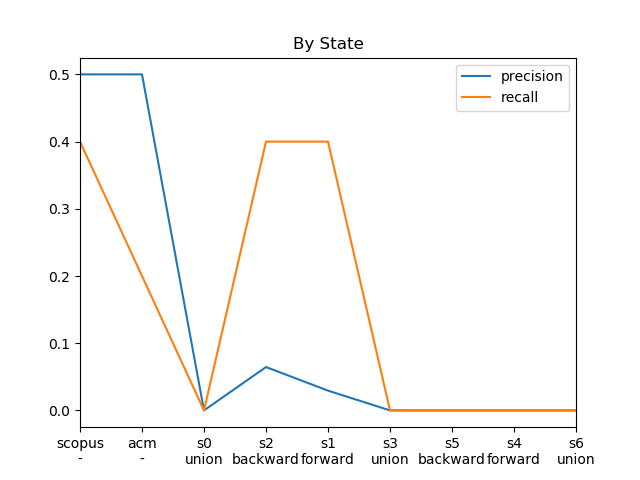

In [296]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


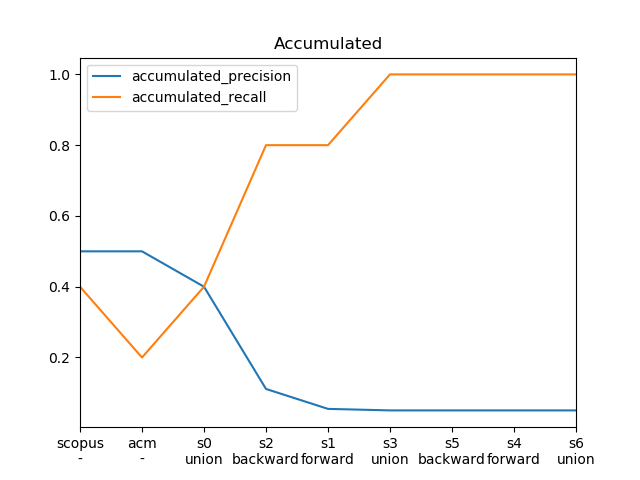

In [290]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

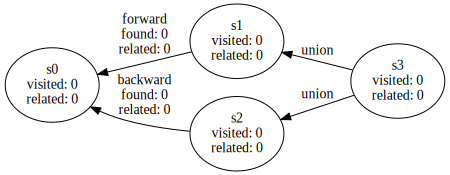

In [178]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [179]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

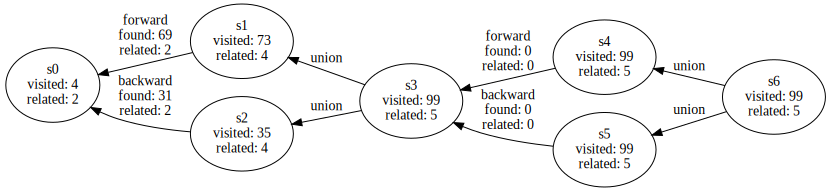

In [113]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [114]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.050505050505050504
Recall E4
1.0


In [115]:
state.find("s0").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [116]:
state.find("s2").related

{A comparison of cross-company and within-company effort estimation models for web applications,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross versus within-company cost estimation studies: A systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [117]:
state.find("s0").visited

{Using public domain metrics to estimate software development effort,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [118]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [119]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [120]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Building software cost estimation models using homogenous data,
 Cross versus within-company cost estimation studies: A systematic review}

In [121]:
len(state.find("s1").delta_visited)

69

In [122]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [123]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [124]:
search_state = strategy.initial
search_state.related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

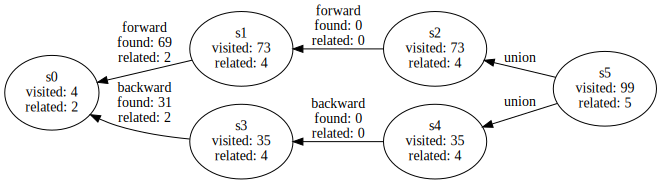

In [125]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [126]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.050505050505050504
Recall E5
1.0


In [127]:
state.find("s0").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [128]:
state.find("s1").related 

{Building software cost estimation models using homogenous data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross versus within-company cost estimation studies: A systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [129]:
state.find("s5").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross versus within-company cost estimation studies: A systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [130]:
sx, sy = state.previous[0]

sx.related & sy.related


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross versus within-company cost estimation studies: A systematic review,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [131]:
sx.name

's2'

In [132]:
sy.name

's4'

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

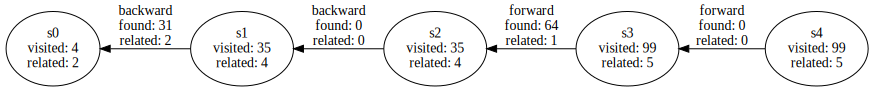

In [133]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [134]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.050505050505050504
Recall E6
1.0


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

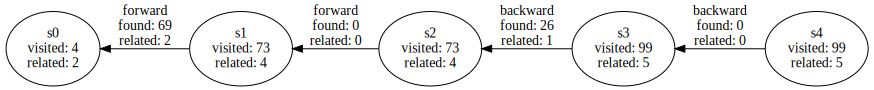

In [135]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [136]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.050505050505050504
Recall E7
1.0


# Análise das Estratégias

In [137]:
%matplotlib notebook
import pandas as pd

In [138]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.4
E2,E2,0.050505,1.0
E2,E2,0.050505,1.0
E4,E4,0.050505,1.0
E5,E5,0.050505,1.0
E6,E6,0.050505,1.0
E7,E7,0.050505,1.0


<IPython.core.display.Javascript object>


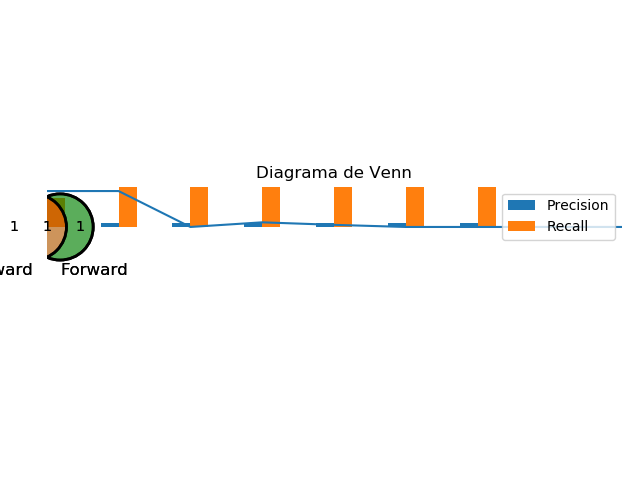

In [139]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [140]:
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.4
E2,E2,0.050505,1.0
E2,E2,0.050505,1.0
E4,E4,0.050505,1.0
E5,E5,0.050505,1.0
E6,E6,0.050505,1.0
E7,E7,0.050505,1.0


In [145]:
df.to_csv("estrategias.csv")